In [179]:
import pandas as pd
import numpy as np
import scipy as sp
import sympy as smp
import matplotlib.pyplot as plt

In [180]:
df = pd.read_csv("coil_position_data.txt")
df.columns=['w_t','LV']
df.head()

,w_t,LV
0,0.000000,3.000000
1,2.170418,3.023155
2,3.183280,3.037627
3,4.340836,3.049204
4,6.221865,3.057887


In [181]:
w_t = smp.symbols('w_t', real=True) # 
LV_spline = smp.interpolating_spline( 3 , w_t , df['w_t'] , df['LV'])
LV_spline

LV_func = smp.lambdify(w_t, LV_spline, "numpy")
#LV_func = lambda wheel_travel: LV_spline.subs( w_t , wheel_travel)

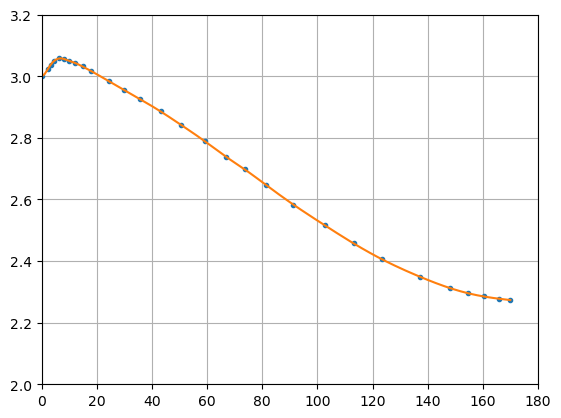

In [182]:
plt.plot(df['w_t'],df['LV'],'.')

w_t_step = 1 #mm
w_t_vector = np.arange(0,max(df['w_t'])+w_t_step,w_t_step)
LV_vector = LV_func(w_t_vector)
#LV_vector[0]=3
plt.plot(w_t_vector,LV_vector)

plt.grid()
plt.ylim(bottom=2,top=3.2)
plt.xlim(left=0,right=180)
plt.show()

In [183]:
inv_LV = smp.lambdify(w_t, 1/LV_spline, "numpy") 

# Computing this integral every time i need to determine shock stroke is slow
#from scipy.integrate import quad
#s_s_func = lambda wheel_travel: quad( inv_LV , 0 , wheel_travel )[0]

## So i'll create a vector with the shock stroke as function of wheel travel
inv_LV_vector = inv_LV(w_t_vector)
s_s_vector=sp.integrate.cumulative_simpson(  inv_LV_vector , x=w_t_vector , initial=0)


In [184]:
# and then a spline
shock_stroke_spline = smp.interpolating_spline( 3 , w_t , w_t_vector , s_s_vector)

In [185]:
# and then a function
s_s_func = smp.lambdify(w_t, shock_stroke_spline, "numpy")

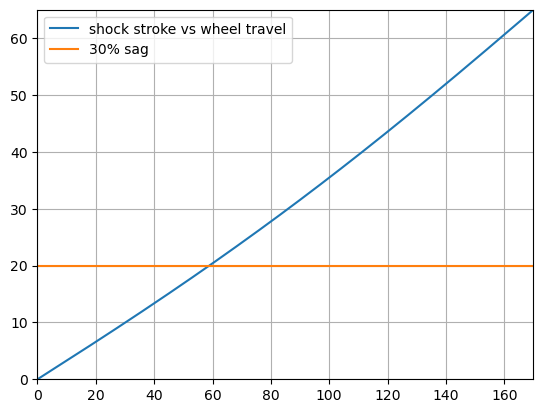

In [186]:
plt.plot(w_t_vector,s_s_vector,label="shock stroke vs wheel travel")
plt.plot([0,170],[20,20],label="30% sag")
plt.legend()
plt.grid()
plt.ylim(bottom=0,top=65)
plt.xlim(left=0,right=170)
plt.show()

In [807]:
chainstay=440
wheel_base=1200
rear_split= 1 - chainstay/wheel_base

mass = 80

shock_max_stroke = max(s_s_vector)

#Coil
k_spring = 70050.734 # N/m = 400 lbs/in

#Bumper
bumper_height = 15 # milimeter
bumper_exponent = 2
#this equation makes the fully compressed bumper force equal the fuly compressed coil force
# i have no ideia of the spring behaviour of the bumper
k_bumper = (k_spring*shock_max_stroke*1e-3)/((bumper_height*1e-3)**bumper_exponent)# N/m 

# Damper
Rebound=3e3
LSC_preload = 0 # N
HSC_transition_velocity = 1.5 # m/s
LSC_slope = 6.6e3
HSC_transition_force= LSC_slope*HSC_transition_velocity
HSC_slope = LSC_slope #6e3 # N*s/m

In [808]:
F_spring_func = lambda wheel_travel: k_spring * s_s_func(wheel_travel)/1000
    #n Newtons


F_w_spring_func = lambda wheel_travel: F_spring_func(wheel_travel) / LV_func(wheel_travel)
    # Newtons


def F_bumper_func (wheel_travel): 
    if isinstance(wheel_travel, float):
        wheel_travel = [wheel_travel]
        
    res=[]
    for i in wheel_travel:
        if (s_s_func(i) > shock_max_stroke - bumper_height):
            res.append(k_bumper*((s_s_func(i)-(shock_max_stroke-bumper_height))/1000)**bumper_exponent  )
        else:
            res.append(0)
    return res
    # Newtons

F_w_bumper_func = lambda wheel_travel: F_bumper_func(wheel_travel) / LV_func(wheel_travel)
    # Newtons


def F_damper_func( wheel_travel , wheel_velocity): 
    # Travel = milimeter , Velocity = meter/s

    shock_velocity = wheel_velocity / LV_func(wheel_travel)

    if shock_velocity < 0: # Rebound
        force = Rebound*shock_velocity
    elif shock_velocity<HSC_transition_velocity: # LSC
        force = LSC_preload + LSC_slope*shock_velocity
    else:
        force = LSC_preload + HSC_transition_force + HSC_slope*(shock_velocity-HSC_transition_velocity)
        
    return force
    
    
F_w_damper_func = lambda wheel_travel , wheel_velocity: F_damper_func( wheel_travel , wheel_velocity) / LV_func(wheel_travel)
    # Newtons


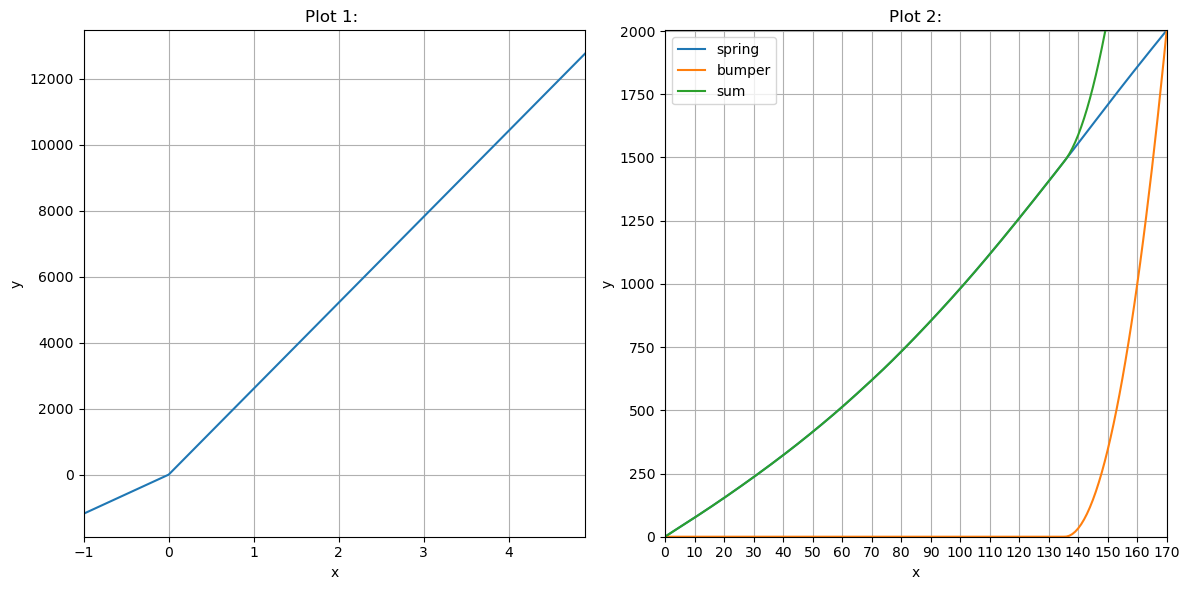

In [809]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot data on the first subplot
velocities = np.arange(-1,5,0.1)
ax1.plot(velocities , [ F_damper_func(100 , i) for i in velocities])
ax1.set_title('Plot 1: ')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.grid()
ax1.set_xlim(left=min(velocities),right=max(velocities))

# Plot data on the second subplot
F_w_spring_vector = F_w_spring_func(w_t_vector)
F_w_bumper_vector = F_w_bumper_func(w_t_vector)
F_w_spring_bumper_sum = np.array(F_w_spring_vector) + np.array(F_w_bumper_vector) 
ax2.plot( w_t_vector , F_w_spring_vector , label="spring")
ax2.plot( w_t_vector , F_w_bumper_vector , label="bumper")
ax2.plot(w_t_vector ,F_w_spring_bumper_sum , label="sum")
ax2.legend()
ax2.grid()
ax2.set_ylim(bottom=0,top=max(np.concatenate((F_w_spring_vector,F_w_bumper_vector))))
ax2.set_xticks(np.arange(0, 180, 10))
ax2.set_xlim(left=0,right=170)
ax2.set_title('Plot 2:')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [823]:
fall_height = 1

#conditions at initial ground contact
x =  w_t_vector[-1]*1e-3 #meters
v = -np.sqrt(2*9.81*fall_height)
a = 0
wheel_travel = w_t_vector[-1] - x*1e3 #milimeters
wheel_velocity = -v #meters

x_list=[x]
v_list=[v]
a_list=[a]
wheel_travel_list=[wheel_travel]
wheel_velocity_list=[wheel_velocity]
force_list=[0]
force_spring_bumper_list=[0]
force_damper_list=[0]

t=0
t_step=1e-5
t_final=1
t_list=[t]

r_mass=rear_split*mass

# Simulation end conditions
while (t<t_final) and (wheel_travel<=w_t_vector[-1]) and (x<=x_list[0])  :#and (wheel_velocity > 0)
    #print("x( t= ",t," ) = ",x)
    force_spring_bumper = F_w_spring_func(wheel_travel) + F_w_bumper_func(wheel_travel).item()
    force_damper = F_w_damper_func(wheel_travel , wheel_velocity)
    force_gravity = r_mass*9.81
    force = force_spring_bumper + force_damper - force_gravity
    a = force/r_mass
    v = v + a*t_step
    x = x + v*t_step + 0.5*a*(t_step**2)
    
    wheel_travel = w_t_vector[-1] - x*1e3 #milimeters
    wheel_velocity = (wheel_travel - wheel_travel_list[-1])*1e-3/t_step #meters

    a_list.append(a)
    v_list.append(v)
    x_list.append(x)
    wheel_travel_list.append(wheel_travel)
    wheel_velocity_list.append(wheel_velocity)
    force_list.append(force)
    force_spring_bumper_list.append(force_spring_bumper)
    force_damper_list.append(force_damper)

    t += t_step
    #print("t= ",t)
    t_list.append(t)

if x<=0 or (wheel_travel>=w_t_vector[-1]):
    print("Bottom out!!!")
else:
    print("Travel used:",round(wheel_travel,1))

Travel used: 58.5


(0.0, 1.0000099999980838)

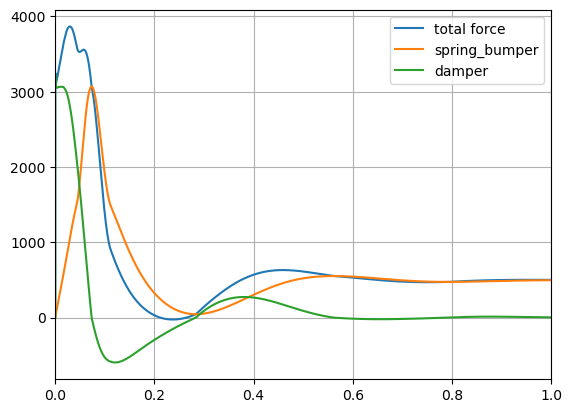

In [824]:
plt.plot(t_list,np.array(force_spring_bumper_list)+np.array(force_damper_list), label="total force")
plt.plot(t_list,force_spring_bumper_list, label="spring_bumper")
plt.plot(t_list,force_damper_list, label="damper")
plt.legend()
plt.grid()
plt.xlim(left=0,right=t)

In [ ]:
potencial_energy = r_mass*9.81*fall_height
print("potencial_energy = ",potencial_energy)


wheel_work = sp.integrate.simpson(force_list,x_list)
print("wheel_work = ",wheel_work)

spring_energy = sp.integrate.simpson(force_spring_bumper_list,x_list)
print("spring_energy = ",spring_energy)

damper_work = sp.integrate.simpson(force_damper_list,x_list)
print("damper_work = ",damper_work)


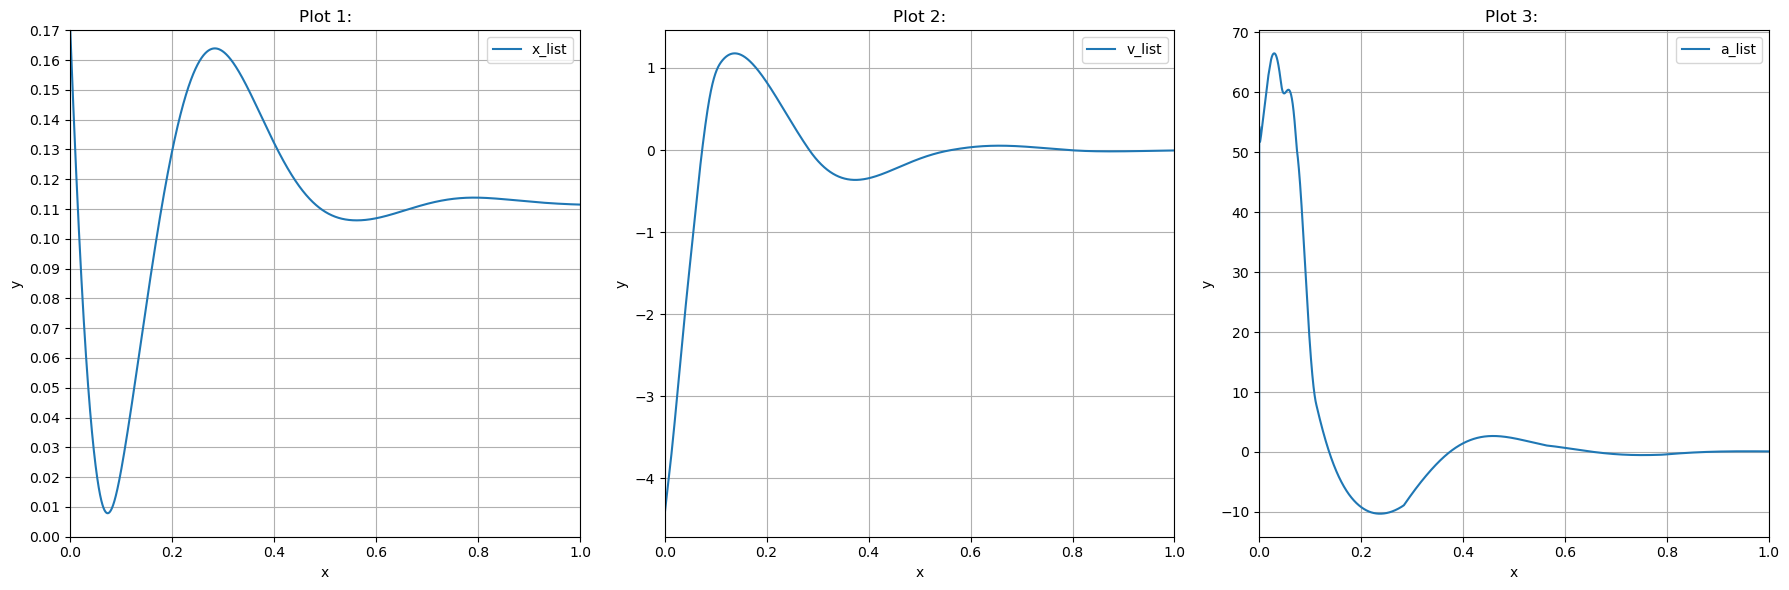

In [826]:
# Create a figure with three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot data on the first subplot
ax1.plot(t_list,x_list, label="x_list")
ax1.grid()
ax1.legend()
ax1.set_ylim(bottom=0,top=0.170)
ax1.set_yticks(np.arange(0, 0.180, 0.01))
ax1.set_xlim(left=0,right=t)
ax1.set_title('Plot 1:')
ax1.set_xlabel('x')
ax1.set_ylabel('y')


# Plot data on the second subplot
ax2.plot(t_list,v_list,label="v_list")
ax2.grid()
ax2.legend()
ax2.set_xlim(left=0,right=t)
ax2.set_title('Plot 2:')
ax2.set_xlabel('x')
ax2.set_ylabel('y')


# Plot data on the third subplot
ax3.plot(t_list,a_list,label="a_list")
ax3.grid()
ax3.legend()
ax3.set_xlim(left=0,right=t)
ax3.set_title('Plot 3: ')
ax3.set_xlabel('x')
ax3.set_ylabel('y')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

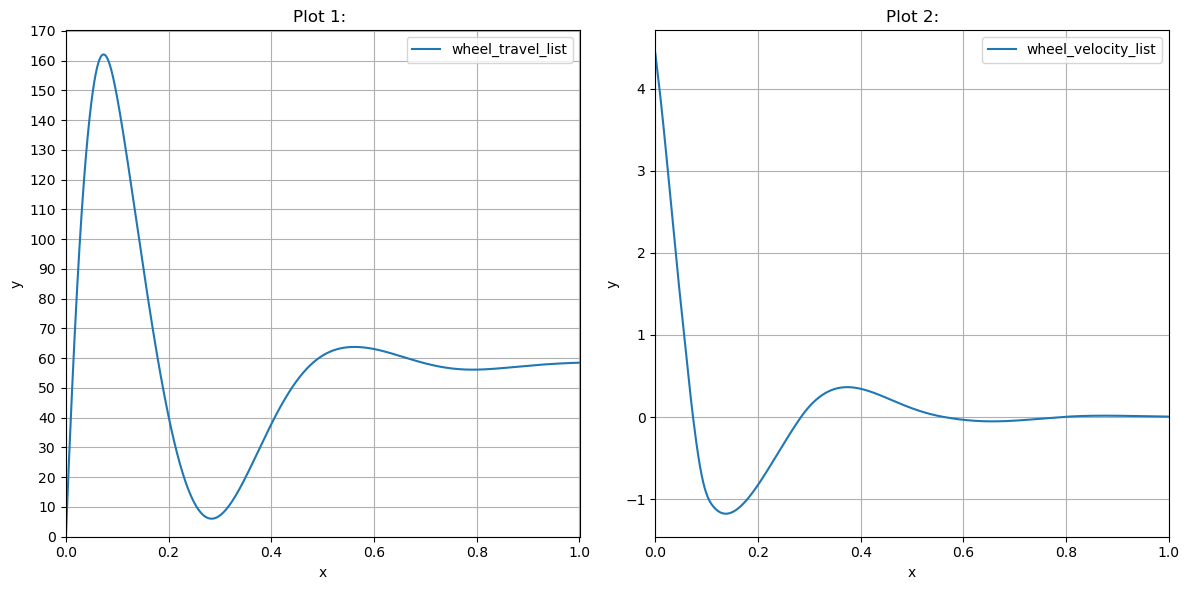

In [827]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot data on the first subplot
ax1.plot(t_list,wheel_travel_list, label="wheel_travel_list")
ax1.legend()
ax1.grid()
ax1.set_yticks(np.arange(0, 180, 10))
ax1.set_xlim(left=0,right=t)
ax1.set_ylim(bottom=0)
ax1.set_title('Plot 1: ')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Plot data on the second subplot
ax2.plot(t_list,wheel_velocity_list,label="wheel_velocity_list")
ax2.legend()
ax2.grid()
ax2.set_xlim(left=0,right=t)
ax2.set_title('Plot 2:')
ax2.set_xlabel('x')
ax2.set_ylabel('y')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()